# Author - Mitesh Singh - (SBU ID - 00154659)

References 
1. The json load function has been obtained from https://www.kaggle.com/kabure/exploring-the-consumer-patterns-simple-eda/notebook

2. The lightGBM function has been obtained from https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue

Both these functions have been made modular and customized by the author as per the needs

Human References:
Udbhav Udbhav, Nikhil Siddhartha, Vivek Kumar Sah

In [30]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

import os # it's a operational system library, to set some informations
import random # random is to generate random values
import json 
from pandas.io.json import json_normalize 

import lightgbm as lgb
from sklearn import preprocessing

# Task 0 - Data Loading

In [37]:
# Code to transform the json format columns in table - Obtained from Leonardo Ferreira Kernel

columns = ['device', 'geoNetwork', 'totals', 'trafficSource'] # Columns that have json format

# p is a fractional number to skiprows and read just a random sample of the our dataset. 
p = 1 # *** In this case we will use 50% of data set *** #

def json_read(df):
    #joining the [ path + df received]
    data_frame = df
    
    #Importing the dataset
    df = pd.read_csv(data_frame, 
                     converters={column: json.loads for column in columns}, # loading the json columns properly
                     dtype={'fullVisitorId': 'str', 'date': object, 'visitId': object, 'visitStartTime': object},
                     skiprows=lambda i: i>0 and random.random() > p)# Number of rows that will be imported randomly
    
    for column in columns: #loop to finally transform the columns in data frame
        #It will normalize and set the json to a table
        column_as_df = json_normalize(df[column]) 
        # here will be set the name using the category and subcategory of json columns
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        # after extracting the values, let drop the original columns
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    # Printing the shape of dataframes that was imported     
    print(f"Loaded {os.path.basename(data_frame)}. Shape: {df.shape}")
    return df # returning the df after importing and transforming

train = json_read("train.csv")
test = json_read("test.csv")
testData.head()

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.campaign,trafficSource.medium,trafficSource.source,visit_day,visit_month,visit_year,visit_hour,visit_minute,visit_second,visit_week
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,...,(not set),organic,google,16,10,2017,10,50,24,0
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,...,(not set),organic,google,16,10,2017,17,38,42,0
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,...,(not set),organic,google,16,10,2017,8,40,20,0
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,...,(not set),organic,google,16,10,2017,22,38,50,0
4,Organic Search,20171016,2314544520795440038,2314544520795440038_1508217442,Not Socially Engaged,1508217442,1,1508217442,Safari,not available in demo dataset,...,(not set),organic,google,16,10,2017,5,17,22,0


In [218]:
trainData = train
testData = test

# Task 1 - Data Cleaning

I performed the following steps to clean the data 

1. Remove columns which have high percentage of null values
2. Remove columns which have constant values
3. Remove columns which are not present in test dataset. Ex. trafficSource.campaignCode
4. Remove columns which will not be used for any prediction or analysis Ex. sessionId
5. Impute appropriate values in remaining columns which have null values

Total number of columns reduced from 55 to 24

Anamolies still existing after cleaning the dataset

1. Many string categorical columns like country, metro, etc have null, NAN or dirty values like (not set), (not provided). Such values were not cleaned.

2. I observed that few entries had mismatch between region and city. Ex. for 1 case, city was San Francisco but region was Ireland. As such entries were very few, they have not been cleaned.

In [179]:
# Remove columns in your model which have very large number of null values
numberOfDataPoints = trainData.shape[0];
nullCountPerColumn = trainData.isnull().sum()
percentageOfNull = (nullCountPerColumn/numberOfDataPoints) * 100
percentageOfNull.sort_values(ascending = False)

trafficSource.campaignCode                           99.999889
trafficSource.adContent                              98.788694
totals.transactionRevenue                            98.725728
trafficSource.adwordsClickInfo.page                  97.625195
trafficSource.adwordsClickInfo.adNetworkType         97.625195
trafficSource.adwordsClickInfo.slot                  97.625195
trafficSource.adwordsClickInfo.isVideoAd             97.625195
trafficSource.adwordsClickInfo.gclId                 97.614018
trafficSource.isTrueDirect                           69.678073
trafficSource.referralPath                           63.377425
trafficSource.keyword                                55.655102
totals.bounces                                       50.132407
totals.newVisits                                     22.198012
totals.pageviews                                      0.011066
device.isMobile                                       0.000000
device.flashVersion                                   0

In [219]:
#drop the columns which have lots of NAN values
columnnsToBeDropped = [
                       'trafficSource.adContent',
                       'trafficSource.adwordsClickInfo.adNetworkType', 
                       'trafficSource.adwordsClickInfo.slot', 
                       'trafficSource.adwordsClickInfo.page', 
                       'trafficSource.adwordsClickInfo.isVideoAd',
                       'trafficSource.adwordsClickInfo.gclId',
                       'trafficSource.isTrueDirect',
                       'trafficSource.referralPath',
                       'trafficSource.keyword',
                       'totals.bounces',
                       'totals.newVisits']
trainData = trainData.drop(columns = columnnsToBeDropped)
testData = testData.drop(columns = columnnsToBeDropped)

#dropping columns which are not there in test data. 
trainData = trainData.drop(columns = ['trafficSource.campaignCode'])

#dropping id columns which will not be used for analysis and prediction
train_df = trainData.drop(columns = ['sessionId'])
test_df = testData.drop(columns = ['sessionId'])

print(trainData.shape)
print(testData.shape)


(903653, 43)
(804684, 42)


In [5]:
# There are 12 columns having large number of null values. We will do further analysis on them
trainData.nunique().sort_values()

device.operatingSystemVersion                             1
geoNetwork.cityId                                         1
device.mobileInputSelector                                1
device.mobileDeviceModel                                  1
device.mobileDeviceMarketingName                          1
device.mobileDeviceInfo                                   1
device.mobileDeviceBranding                               1
device.language                                           1
device.flashVersion                                       1
device.screenColors                                       1
device.screenResolution                                   1
device.browserSize                                        1
geoNetwork.latitude                                       1
geoNetwork.longitude                                      1
geoNetwork.networkLocation                                1
socialEngagementType                                      1
totals.visits                           

In [220]:
# Remove those columns for which the unique count is 1
columnWithUniqueCountAs1 = [column for column in trainData.columns if trainData[column].nunique() == 1]
trainData.drop(columnWithUniqueCountAs1, axis=1, inplace=True) 
testData.drop(columnWithUniqueCountAs1, axis=1, inplace=True) 
print(trainData.shape)
print(testData.shape)

(903653, 24)
(804684, 23)


In [221]:
#Fill NaN values with some default values
trainData["totals.transactionRevenue"] = trainData["totals.transactionRevenue"].fillna(0.0).astype(float)
trainData['totals.pageviews'].fillna(1, inplace=True) 
testData['totals.pageviews'].fillna(1, inplace=True)
trainData['totals.hits'].fillna(1, inplace=True) 
testData['totals.hits'].fillna(1, inplace=True)

trainData['totals.pageviews'] = trainData['totals.pageviews'].astype(int)
trainData["totals.hits"] = trainData["totals.hits"].astype(float)
testData['totals.pageviews'] = testData['totals.pageviews'].astype(int)
testData["totals.hits"] = testData["totals.hits"].astype(float)

In [222]:
# Creating additional columns

# 1. Create a new column visit_day from date
def getDayOfVisit(x):
    return datetime.strptime(x, '%Y%m%d').day
trainData['visit_day'] = trainData['date'].map(getDayOfVisit)
testData['visit_day'] = testData['date'].map(getDayOfVisit)

# 2. Create a new column visit_month from date
def getMonthOfVisit(x):
    return datetime.strptime(x, '%Y%m%d').month
trainData['visit_month'] = trainData['date'].map(getMonthOfVisit)
testData['visit_month'] = testData['date'].map(getMonthOfVisit)

# 3. Create a new column visit_day from date
def getYearOfVisit(x):
    return datetime.strptime(x, '%Y%m%d').year
trainData['visit_year'] = trainData['date'].map(getYearOfVisit)
testData['visit_year'] = testData['date'].map(getYearOfVisit)

# 4. Create a new column visit_hour from visitStartTime
def getHourOfVisit(x):
    ts = int(x)
    return datetime.utcfromtimestamp(ts).hour
trainData['visit_hour'] = trainData['visitStartTime'].map(getHourOfVisit)
testData['visit_hour'] = testData['visitStartTime'].map(getHourOfVisit)

# 5. Create a new column visit_hour from visitStartTime
def getMinutesOfVisit(x):
    ts = int(x)
    return datetime.utcfromtimestamp(ts).minute
trainData['visit_minute'] = trainData['visitStartTime'].map(getMinutesOfVisit)
testData['visit_minute'] = testData['visitStartTime'].map(getMinutesOfVisit)

# 6. Create a new column visit_hour from visitStartTime
def getSecondsOfVisit(x):
    ts = int(x)
    return datetime.utcfromtimestamp(ts).second
trainData['visit_second'] = trainData['visitStartTime'].map(getSecondsOfVisit)
testData['visit_second'] = testData['visitStartTime'].map(getSecondsOfVisit)

# 7. Create a new column visit_week from date
def getWeekDayOfVisitDate(x):
    return datetime.strptime(x, '%Y%m%d').weekday()
trainData['visit_week'] = trainData['date'].map(getWeekDayOfVisitDate)
testData['visit_week'] = testData['date'].map(getWeekDayOfVisitDate)

print(trainData.shape)
print(testData.shape)

(903653, 31)
(804684, 30)


# Task 2 - 3 plots for correlations

In [224]:
#Before taking correlation remove all rows where transaction revenue is 0 or NULL

#y = trainData[trainData["totals.transactionRevenue"] >= 0.01]
correlation = trainData.corr(method='pearson')
correlation.style.format("{:.2}").background_gradient(cmap=plt.get_cmap('RdYlGn'), axis=1)


,visitNumber,device.isMobile,totals.hits,totals.pageviews,totals.transactionRevenue,visit_day,visit_month,visit_year,visit_hour,visit_minute,visit_second,visit_week
visitNumber,1.0,-0.038,0.041,0.043,0.051,-0.0028,-0.011,0.0079,0.025,-0.0014,-0.0014,-0.02
device.isMobile,-0.038,1.0,-0.03,-0.03,-0.017,0.0017,-0.11,0.14,-0.025,-0.0021,-0.0035,0.079
totals.hits,0.041,-0.03,1.0,0.98,0.15,-0.005,0.0031,-0.018,0.017,-0.0027,-0.00059,-0.012
totals.pageviews,0.043,-0.03,0.98,1.0,0.16,-0.0048,-0.0023,-0.011,0.019,-0.0027,-0.00064,-0.012
totals.transactionRevenue,0.051,-0.017,0.15,0.16,1.0,0.00056,-0.0028,0.0032,0.011,-0.0014,-4.8e-05,-0.0078
visit_day,-0.0028,0.0017,-0.005,-0.0048,0.00056,1.0,-0.017,-0.0011,-0.0031,0.00025,0.00074,-0.019
visit_month,-0.011,-0.11,0.0031,-0.0023,-0.0028,-0.017,1.0,-0.87,-0.025,-0.00016,-0.0009,0.0081
visit_year,0.0079,0.14,-0.018,-0.011,0.0032,-0.0011,-0.87,1.0,0.02,-0.00036,0.0015,-0.0028
visit_hour,0.025,-0.025,0.017,0.019,0.011,-0.0031,-0.025,0.02,1.0,-0.0031,-0.0011,-0.026
visit_minute,-0.0014,-0.0021,-0.0027,-0.0027,-0.0014,0.00025,-0.00016,-0.00036,-0.0031,1.0,-0.00083,0.00039


1. Time of the day in hours vs Average Transaction Revenue

The time is calculated as UTC timestamp. The plot gives us an idea that people are more active 

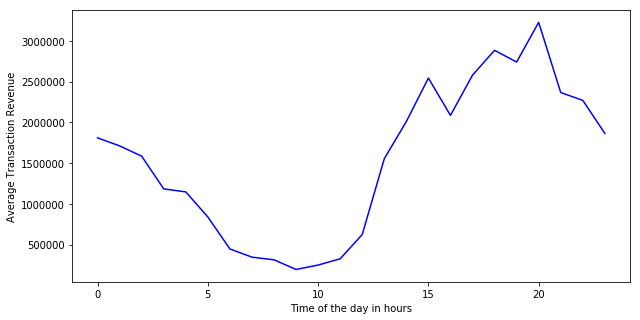

In [225]:
groupby_visit_hour = trainData.groupby(['visit_hour']).mean()
plt.plot(groupby_visit_hour['totals.transactionRevenue'], color='blue')
plt.xlabel('Time of the day in hours')
plt.ylabel('Average Transaction Revenue')
plt.show()

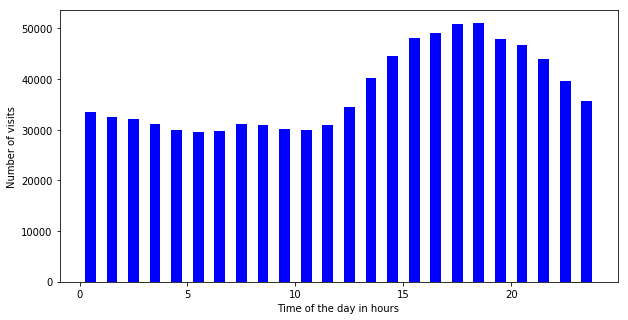

In [226]:
plt.hist(trainData['visit_hour'], color='blue', rwidth=0.5, bins=np.arange(trainData['visit_hour'].min(), trainData['visit_hour'].max()+2))
plt.xlabel('Time of the day in hours')
plt.ylabel('Number of visits')
plt.show()

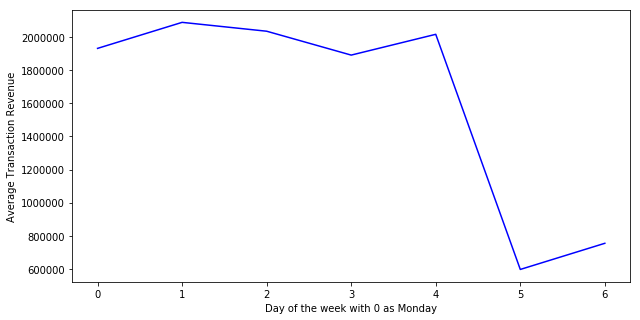

In [227]:
groupby_visit_weekday = trainData.groupby(['visit_week']).mean()
plt.plot(groupby_visit_weekday['totals.transactionRevenue'], color='blue')
plt.xlabel('Day of the week with 0 as Monday')
plt.ylabel('Average Transaction Revenue')
plt.show()


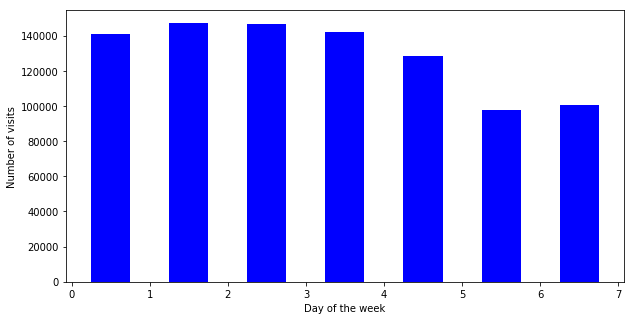

In [228]:
plt.hist(trainData['visit_week'], color='blue', rwidth=0.5, bins=np.arange(trainData['visit_week'].min(), trainData['visit_week'].max()+2))
plt.xlabel('Day of the week')
plt.ylabel('Number of visits')
plt.show()

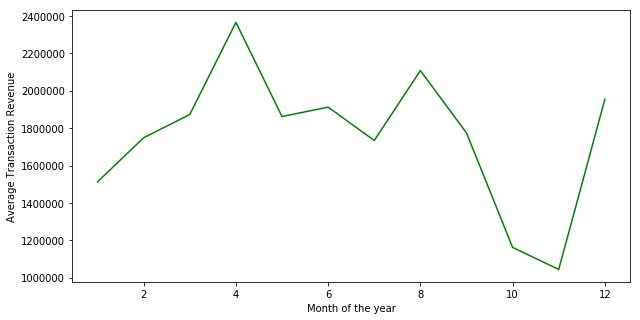

In [229]:
groupby_visit_month = trainData.groupby(['visit_month']).mean()
plt.plot(groupby_visit_month['totals.transactionRevenue'], color='green')
plt.xlabel('Month of the year')
plt.ylabel('Average Transaction Revenue')

plt.show()

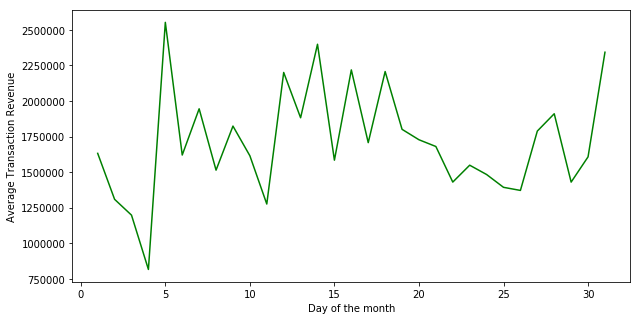

In [230]:
groupby_visit_day = trainData.groupby(['visit_day']).mean()
plt.plot(groupby_visit_day['totals.transactionRevenue'], color='green')
plt.xlabel('Day of the month')
plt.ylabel('Average Transaction Revenue')

plt.show()

# Task 3 - Cluster the variables with geographic info available

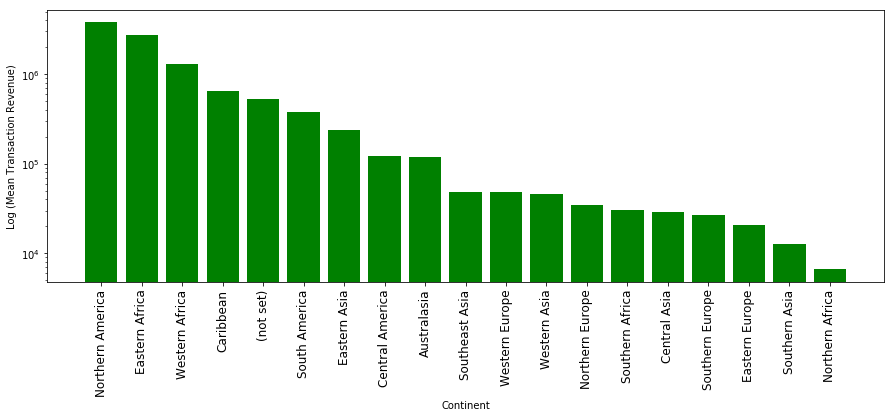

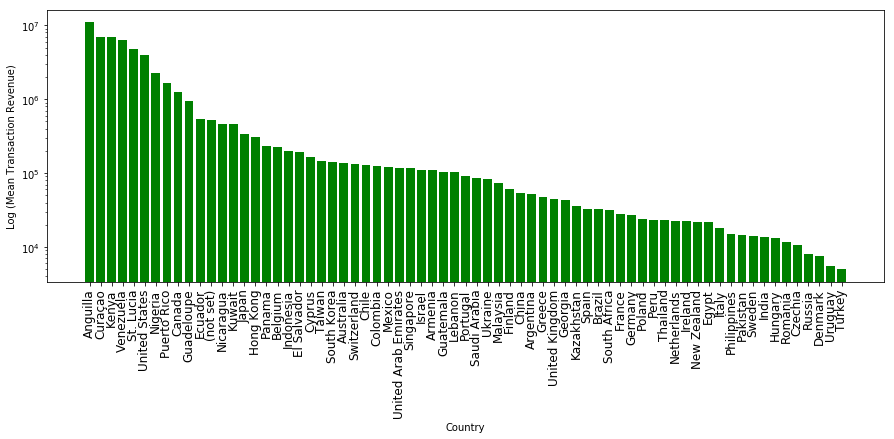

In [232]:
# plotABarChart function -  obtained from Udbhav Kernel
def plotABarChart(xKeys, y, xLabel, yLabel, log = False, figsize = [15.0, 5.0], rot=90):
    x = np.arange(xKeys.shape[0])
    plt.rcParams['figure.figsize'] = figsize
    plt.bar(x, y, log = log, color="green")
    plt.ylabel(yLabel)
    plt.xlabel(xLabel)
    plt.xticks(x, xKeys, fontsize=12, rotation=rot)
    plt.show()
    
subContinents = trainData.groupby("geoNetwork.subContinent").mean().reset_index()
subContinents = subContinents[subContinents["totals.transactionRevenue"] > 0]
subContinents = subContinents.sort_values(by=['totals.transactionRevenue'], ascending = False)
plotABarChart(subContinents["geoNetwork.subContinent"].values, subContinents["totals.transactionRevenue"].values, 'Continent', 'Log (Mean Transaction Revenue)', True)

countries = trainData.groupby("geoNetwork.country").mean().reset_index()
countries = countries[countries["totals.transactionRevenue"] > 0]
countries = countries.sort_values(by=['totals.transactionRevenue'], ascending = False)
plotABarChart(countries["geoNetwork.country"].values, countries["totals.transactionRevenue"].values, 'Country', 'Log (Mean Transaction Revenue)', True)



# Task 4 - Define a buying score for each user

1. Logistic Regression Model - Decide the features and binary class for logistic regression model

In [233]:
trainLR = trainData

columnsForOneHotEncoding = ['device.deviceCategory', 'device.isMobile', 'geoNetwork.continent', 'geoNetwork.city', 'geoNetwork.subContinent', 'channelGrouping']
X = trainLR[columnsForOneHotEncoding]
X = pd.get_dummies(X, columns=columnsForOneHotEncoding)
X['totals.pageviews'] = trainData['totals.pageviews']
X['totals.hits'] = trainData['totals.hits']
X['visit_year'] = trainData['visit_year']
X['visit_month'] = trainData['visit_month']
X['visit_day'] = trainData['visit_day']
X['visit_hour'] = trainData['visit_hour']
X['visit_minute'] = trainData['visit_minute']
X['visit_second'] = trainData['visit_second']
X['visitNumber'] = trainData['visitNumber']

def doesUserBuy(x):
    return 1 if x > 0.001 else 0
Y = pd.DataFrame()
Y['doesUserBuy'] = trainLR['totals.transactionRevenue'].map(doesUserBuy)


2. Split train data into training set and validation set so that accuracy of logistic regression model can be calculated on validation data

In [234]:
# Split the train dataset into development and valid based on time 
perm = np.random.permutation(X.index)
m = len(X.index)
train_end = int(0.8 * m)
test_end = int(0.2 * m) + train_end

X_train = X.iloc[perm[:train_end]]
X_test = X.iloc[perm[train_end:test_end]]

Y_train = Y.iloc[perm[:train_end]]
Y_test = Y.iloc[perm[train_end:test_end]]

Id_Train = trainLR["fullVisitorId"][perm[:train_end]]
Id_Test = trainLR["fullVisitorId"][perm[train_end:test_end]]

Revenue_Train = trainLR['totals.transactionRevenue'][perm[:train_end]]
Revenue_Test = trainLR['totals.transactionRevenue'][perm[train_end:test_end]]

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
Id_Train.reset_index(drop=True, inplace=True)
Id_Test.reset_index(drop=True, inplace=True)
Revenue_Train.reset_index(drop=True, inplace=True)
Revenue_Test.reset_index(drop=True, inplace=True)

Id_Test.head(10)

0     962968224722344719
1    9839034753807489913
2    9637023476808058644
3    0166714065624374803
4    9973571671481160644
5    3300622118189485946
6    0012021439019164032
7    9444968272609420975
8     403124097952602818
9    8355729127276599774
Name: fullVisitorId, dtype: object

3. Train the model, predict and calculate probabilities

In [235]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, Y_train)

probabilities = logreg.predict_proba(X_test)
trainMeanAcc = logreg.score(X_train, Y_train)
valMeanAcc = accuracy_score(Y_test["doesUserBuy"], logreg.predict(X_test))

print("Train Mean Accuracy For Logistic Regression On Randomly Sampled Train Data ", trainMeanAcc)
print("Validation Mean Accuracy For Logistic Regression On Randomly Sampled Validation Data ", valMeanAcc)
buying_score = pd.concat([Id_Test, Revenue_Test, Y_test["doesUserBuy"], pd.DataFrame(probabilities)], axis=1)
buying_score.sort_values(by=1, ascending=False).head(10)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Mean Accuracy For Logistic Regression On Randomly Sampled Train Data  0.9866278796329341
Validation Mean Accuracy For Logistic Regression On Randomly Sampled Validation Data  0.9865268632767111


,fullVisitorId,totals.transactionRevenue,doesUserBuy,0,1
111103,6879336706336070910,1.339500e+08,1,0.000000e+00,1.000000
51657,9264804092676520813,1.520530e+09,1,0.000000e+00,1.000000
89541,4636052301667930460,0.000000e+00,0,7.771561e-15,1.000000
90724,743123551680199202,1.038200e+08,1,1.421085e-14,1.000000
170663,9634718394347160889,2.504300e+08,1,7.487975e-09,1.000000
143805,1106901861011569877,0.000000e+00,0,4.108179e-08,1.000000
12443,7480579182178358481,2.695000e+07,1,3.890673e-07,1.000000
38290,2026495143571924795,0.000000e+00,0,1.343741e-06,0.999999
90315,3979618861854336423,1.890180e+09,1,2.247271e-06,0.999998
99083,127019947788366078,2.793000e+07,1,4.554559e-06,0.999995


Approach
I have split training data into 80% training data and 20% validation data.
I have taken all numerical columns and few categorical columns so that the model could be trained in a reasonable time. I have considered 2 classes 
a.) 1 when transaction revenue exists 
b.) 0 when transaction revenue does not exist

Analysis

After running the model, we find that training accuracy and validation accuracy are very high (98%) and almost equal. Ideally, validation accuracy should have been less than training accuracy.
This is happening because of imbalanced dataset. Most of the data in training and testing set belong to class 0.

COnclusion
For top 10, 6 out of 4 values are correctly classified. This unbalanced dataset issue can be resolved if we provide some weight to class with lower frequency. Another great way to fix this would be to use Light Gradient Boost Model which we have explored in the next section.

# Task 5 - Identify external data set

Dataset 1 - https://timezonedb.com/
The given dataset has given all the datapoints in UTC timezone. In order to analyze revenue in a particular geographical area, timezones would be an extremely useful feature. Dataset 1 gives free time zone database for cities of the world. This can be easily incorporated.

Dataset 2 - https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD
In general, countries with higher GDP have high chances of buying products online. Thus analysing data of a particular country and correlating with GDP could give a lot of  insightful info.


# Task 6 - Build the prediction model for kaggle

In [236]:
# References - This piece is modified version of SRK Kernel obtained on Kaggle
train_df = trainData
test_df = testData
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values

cat_cols = ["device.browser", 
            "device.deviceCategory", 
            "device.operatingSystem", 
            "trafficSource.source", 
            "trafficSource.medium", 
            "trafficSource.campaign",
            "geoNetwork.continent", 
            "geoNetwork.subContinent", 
            "geoNetwork.country",
            "geoNetwork.city",
            "geoNetwork.metro",
            "geoNetwork.region",
            "channelGrouping",
            "geoNetwork.networkDomain"]


for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))
    
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visit_year", "visit_day","visit_month", "visit_hour", "visit_minute", "visit_second", "device.isMobile"]    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

device.browser
device.deviceCategory
device.operatingSystem
trafficSource.source
trafficSource.medium
trafficSource.campaign
geoNetwork.continent
geoNetwork.subContinent
geoNetwork.country
geoNetwork.city
geoNetwork.metro
geoNetwork.region
channelGrouping
geoNetwork.networkDomain


In [241]:
# Split the train dataset into development and valid based on time 

def getTrainTestPermuteForDataframeIndex(df, trainFraction, testFraction):
    dfSize = len(df.index)
    perm = np.random.permutation(df.index)
    trainEnd = int(trainFraction * dfSize)
    validateEnd = int(testFraction * dfSize) + trainEnd
    return perm[:train_end], perm[train_end:validate_end]

permutedTrainIndexArr, permutedTestIndexArr = getTrainTestPermuteForDataframeIndex(train_df, 0.8, 0.2)

dev_df = train_df.iloc[permutedTrainIndexArr]
val_df = train_df.iloc[permutedTestIndexArr]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 


In [242]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.63648
[200]	valid_0's rmse: 1.62805
[300]	valid_0's rmse: 1.62509
[400]	valid_0's rmse: 1.62598
Early stopping, best iteration is:
[315]	valid_0's rmse: 1.62482


In [244]:
from sklearn import metrics

def getMSEOnLGBM(pred_val, val_df):
    pred_val[pred_val<0] = 0
    val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
    val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
    val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
    val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
    mse = np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values)))
    return mse

normalMse = getMSEOnLGBM(pred_val, val_df)
print(normalMse)

1.6201535091464907


In [204]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)


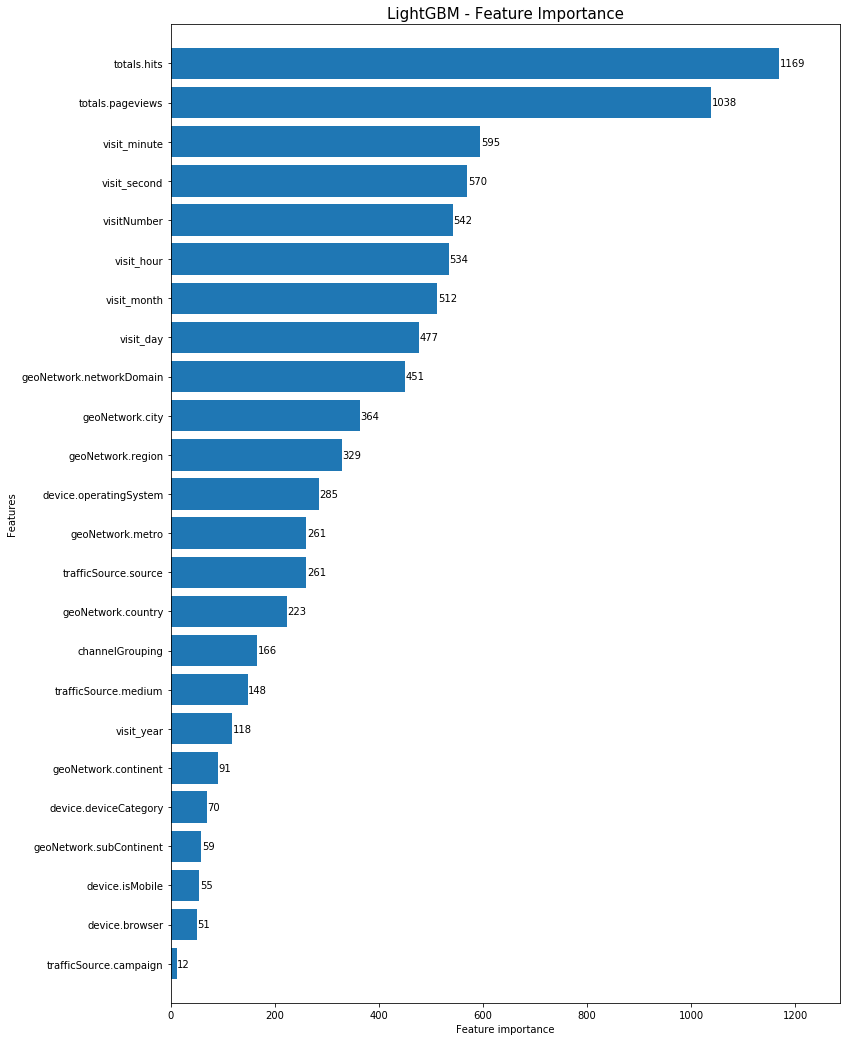

In [205]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

# Task 7 - Perform a permutation test

In [240]:

def permutationTest(dev_X, dev_y, val_X, val_y, test_X, iterations, featureToBePermuted):
    
    mseListAfterPermutation = []
    for i in range(1,iterations+1):
        copy_dev_X = dev_X.copy()
        copy_dev_X[featureToBePermuted] = np.random.permutation(copy_dev_X[featureToBePermuted])
        copy_dev_X[featureToBePermuted] = copy_dev_X[featureToBePermuted].astype(float)
        pred_test, model, pred_val = run_lgb(copy_dev_X, dev_y, val_X, val_y, test_X)
        mse = getMSEOnLGBM(pred_val, val_df)
        mseListAfterPermutation.append(mse)
        print(mse)
    return mseListAfterPermutation

mseListSignificantFeaturePermut = permutationTest(dev_X, dev_y, val_X, val_y, test_X, 10, "totals.hits")
mseListForNotSignificantFeaturePermut = permutationTest(dev_X, dev_y, val_X, val_y, test_X, 10, "trafficSource.campaign")

print("Normal MSE ", normalMse)
print("Trying for significant feature: Hits")
print(mseListSignificantFeaturePermut)
print("Trying for not so significant feature: trafficSource.campaign")
print(mseListForNotSignificantFeaturePermut)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.66438
[200]	valid_0's rmse: 1.66356
Early stopping, best iteration is:
[139]	valid_0's rmse: 1.6624
1.6663498257646165
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.66404
[200]	valid_0's rmse: 1.66222
Early stopping, best iteration is:
[172]	valid_0's rmse: 1.66168
1.6648824378228155
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.66436
[200]	valid_0's rmse: 1.66435
Early stopping, best iteration is:
[150]	valid_0's rmse: 1.66332
1.6669597647471286
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.66392
[200]	valid_0's rmse: 1.6618
Early stopping, best iteration is:
[188]	valid_0's rmse: 1.66166
1.6661943743200456
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.66455
[200]	valid_0's rmse: 1.66423
Early stopping, best iteration is:
[153]	valid_0's 

In [245]:
print("Normal MSE ", normalMse)

Normal MSE  1.6201535091464907
